In [1]:
#%%appyter init
from appyter import magic
magic.init(lambda _=globals: _())

# Compare Sets Appyter
##### This appyter creates a Venn diagram to visualize the intersections between 2-6 user-inputted gene sets. The user has a choice whether to upload a tsv file with the desired genes or to insert the genes into text boxes. 

In [2]:
# Imports
## Venn Diagram
from venn import venn, pseudovenn

## SuperVenn
from supervenn import supervenn

## Data Processing
import csv

## Link to Enrichr
import requests
import json
import time
from IPython.display import display, FileLink, Markdown, HTML

## Fisher Exact Test
import scipy.stats as stats

## UpSet Plot
from upsetplot import from_contents, plot
from matplotlib import pyplot

## Table
import plotly.graph_objects as go

%matplotlib inline

In [3]:
%%appyter hide_code
{% do SectionField(name='section0', title='Compare Gene Sets', subtitle='Create a venn diagram to compare your inputted gene sets', img = 'spiral.png') %}
{% do SectionField(name='section1', title='1. Submit Your Gene Lists', subtitle = 'Upload text files containing your gene list -OR- copy and paste your gene list into each text box below (One gene per row). Default genes are provided below, but you can submit your own gene sets and delete the default data if you wish to do so.', img = 'bulb.png') %}
{% do SectionField(name='section2', title='2. Venn Diagram', subtitle = 'Generate a Venn Diagram from 2-6 inputted sets.', img = 'venndiagram.png') %}
{% do SectionField(name='section3', title='3. UpSet Plot', subtitle = 'Generate an UpSet plot from the inputted sets. This can be useful if you have many sets to compare.', img = 'gears.png') %}
{% do SectionField(name='section4', title='4. Fisher\'s Exact Test (Optional)', subtitle = 'Fisher\'s Exact Test determines whether the overlap of two gene sets is significant.', img = 'brain.png') %}


In [1]:
%%appyter code_exec

# Inputting Lists and Settings
gs1 = {{ FileField(name = 'gs1', label = 'Gene Set 1 File', default = '', examples = {'Example Gene List 1': url_for('static', filename = 'A_Geneshot_PainGenes_GeneRIF_AssociatedGenes.tsv')}, section = 'section1') }}
gs2 = {{ FileField(name = 'gs2', label = 'Gene Set 2 File', default = '', examples = {'Example Gene List 2': url_for('static', filename = 'B_Geneshot_PainGenes_AutoRIF_AssociatedGenes.tsv')}, section = 'section1') }}
gs3 = {{ FileField(name = 'gs3', label = 'Gene Set 3 File', default = '', examples = {'Example Gene List 3': url_for('static', filename = 'C_Geneshot_PainGenes_GeneRIF_PredictedGenes_AutoRIF-CoOccurrence.tsv')}, section = 'section1') }}
gs4 = {{ FileField(name = 'gs4', label = 'Gene Set 4 File', default = '', examples = {'Example Gene List 4': url_for('static', filename = 'D_Geneshot_PainGenes_GeneRIF_PredictedGenes_GeneRIF-CoOccurrence.tsv')}, section = 'section1') }}
gs5 = {{ FileField(name = 'gs5', label = 'Gene Set 5 File', default = '', examples = {'Example Gene List 5': url_for('static', filename = 'E_Geneshot_PainGenes_GeneRIF_PredictedGenes_Enrichr-CoOccurrence.tsv')}, section = 'section1') }}
gs6 = {{ FileField(name = 'gs6', label = 'Gene Set 6 File', default = '', examples = {'Example Gene List 6': url_for('static', filename = 'F_Geneshot_PainGenes_GeneRIF_PredictedGenes_Tagger-CoOccurrence.tsv')}, section = 'section1') }}


gs1Text = {{ TextField(name = 'gs1Text', label = 'Gene Set 1', default = '''TRPV1
OPRM1
TRPA1
COMT
SCN9A
TNF
IL6
IL1B
CRP
BDNF
NGF
SLC6A4
MEFV
TRPM8
TRPV4
CALCA
NTRK1
TLR4
ASIC3
SCN10A
MMP9
CNR1
IL10
CCL2
TNNT2
NPPB
PTGS2
CYP2D6
P2RX3
TACR1''', section = 'section1') }}
gs2Text = {{ TextField(name = 'gs2Text', label = 'Gene Set 2', default = '''TNF
TRPV1
CRP
FOS
PTGS2
NGF
TRPA1
BDNF
CD34
POMC
IVD
IL10
ACE
CASP3
CCL2
TLR4
GFAP
TRPM8
IL6
CD68
KIT
OPRM1
SCN9A
CYP2D6
COMT
CEACAM5
GDNF
NPY
PTH
TRPV4''', section = 'section1') }}
gs3Text = {{ TextField(name = 'gs3Text', label = 'Gene Set 3', default = '''OPRD1
TRPV1
TRPA1
SCN9A
OPRM1
TRPM8
TACR1
OPRK1
TAC1
SCN3B
KCNS1
TRPV3
TRPV4
CACNA1B
CACNA2D2
SCN11A
NTRK1
PENK
SCN1B
OPRL1
PDYN
TRPV2
HTR3C
HTR3A
COMT
P2RX3
TRPM5
DRD2
NGFR
FAAH
ASIC3
PNOC
HTR3B
TRPM4
CACNA2D3
BDKRB1
ASIC4
HTR2A
KCNC2
CHRM4
TRPM3
HTR3E
CACNG2
CHRNA7
SCN10A''', section = 'section1') }}
gs4Text = {{ TextField(name = 'gs4Text', label = 'Gene Set 4', default = '', section = 'section1') }}
gs5Text = {{ TextField(name = 'gs5Text', label = 'Gene Set 5', default = '', section = 'section1') }}
gs6Text = {{ TextField(name = 'gs6Text', label = 'Gene Set 6', default = '', section = 'section1') }}

venndiagram = {{ BoolField(name = 'venndiagram', label = 'Venn Diagram?', default = 'true', description = 'Select \'Yes\' if you would like to generate a Venn diagram. Otherwise, select \'No\'', section = 'section2') }}

scheme = "{{ ChoiceField(name = 'scheme', label = 'Color Scheme', choices = ['viridis', 'cool', 'plasma', 'inferno', 'magma'], default = 'viridis', description = 'Choose a color scheme for your Venn diagram', section = 'section2') }}"

venn_file_format = {{ MultiCheckboxField(name = 'venn_file_format', label = 'File Format', choices = ['png', 'jpg', 'svg'], default = ['png'], description = 'Select the format(s) to save your Venn diagram', section = 'section2') }}

venn_file_name = {{ StringField(name = 'venn_file_name', label = 'File Name', default = 'venn', description = 'Enter a name/description to save your Venn diagram', section = 'section2') }}

upset = {{ BoolField(name = 'upset', label = 'UpSet Plot?', default = 'true', description = 'Select \'Yes\' if you would like to generate an UpSet plot. Otherwise, select \'No\'', section = 'section3') }}

orient = "{{ ChoiceField(name = 'orient', label = 'Orientation', choices = ['Horizontal', 'Vertical'], default = 'Horizontal', description = 'Choose whether your UpSet plot will be displayed horizontally or vertically', section = 'section3') }}"

color = "{{ ChoiceField(name = 'color', label = 'Color', choices = ['Black', 'Blue', 'Red', 'Green', 'Grey', 'Orange', 'Purple', 'Yellow', 'Pink'], default = 'Black', section = 'section3') }}"

counts = {{ BoolField(name = 'counts', label = 'Show Counts?', default = 'true', description = 'This labels the intersection size bars with the cardinality of the intersection.', section = 'section3') }}

percent = {{ BoolField(name = 'percent', label = 'Show Percentages?', default = 'false', description = 'This labels the intersection size bars with the percentage of the intersection relative to the total dataset.', section = 'section3') }}

figure_file_format = {{ MultiCheckboxField(name = 'figure_file_format', label = 'File Format', choices = ['png', 'jpg', 'svg'], default = ['png'], description = 'Select the format to save your figure', section = 'section3') }}

output_file_name = {{ StringField(name = 'output_file_name', label = 'File Name', default = 'UpSet_plot', description = 'Enter a name/description to save your UpSet Plot', section = 'section3') }}

background = {{ IntField(name = 'background', label = 'Background', default = 20000, description = 'Human genes typically have a background of 20,000', section = 'section4') }}

significance = {{ ChoiceField(name = 'significance', label = 'Significance Level', choices = {'0.01': '0.01', '0.05': '0.05', '0.10': '0.10'}, default = '0.05', description = 'Choose a significance level', section = 'section4')}}

fisher_file_format = {{ MultiCheckboxField(name = 'fisher_file_format', label = 'File Format', choices = ['png', 'jpg', 'svg'], default = ['png'], description = 'Select the format to save your table', section = 'section4') }}

fisher_file_name = {{ StringField(name = 'fisher_file_name', label = 'File Name', default = 'fisher_table', description = 'Enter a name/description to save your table', section = 'section4') }}

final_venn_file_names = [str(venn_file_name + '.' + file_type) for file_type in venn_file_format]

final_output_file_names = [str(output_file_name + '.' + file_type) for file_type in figure_file_format]

final_fisher_file_names = [str(fisher_file_name + '.' + file_type) for file_type in fisher_file_format]

UsageError: Cell magic `%%appyter` not found.


In [ ]:
#Color for UpSet plot
color_conversion = {
    'Black': 'black',
    'Blue': 'lightskyblue',
    'Red': 'tomato',
    'Green': 'mediumspringgreen',
    'Grey': 'lightgrey',
    'Orange': 'orange',
    'Purple': 'plum',
    'Yellow': 'yellow',
    'Pink': 'lightpink'
}

color = color_conversion[color]

In [ ]:
# Displaying Figures
def figure_title(label, title):
    display(HTML(f"<div style='font-size:2rem; padding;1rem 0;'><b>{label}</b>: {title}</div>"))

def figure_legend(label, title, content=""):
    display(HTML(f"<div><b>{label}</b>: <i>{title}</i>. {content} </div>"))

In [19]:
%%appyter code_exec
# Helper functions to conver the file upload or text input into gene lists
def file_to_list(str):
    l1 = []
    tsv_file = open(str)
    read_tsv = csv.reader(tsv_file, delimiter = '\t')

    for row in read_tsv:
        l1.append(row[0])

    tsv_file.close()
    return l1

def text_to_list(str):
    l1 = str.splitlines()
    return l1


```python
# Helper functions to conver the file upload or text input into gene lists
def file_to_list(str):
    l1 = []
    tsv_file = open(str)
    read_tsv = csv.reader(tsv_file, delimiter = '\t')
    for row in read_tsv:
        l1.append(row[0])
    tsv_file.close()
    return l1
def text_to_list(str):
    l1 = str.splitlines()
    return l1
```

In [20]:
# Add the appropriate gene lists to the dictionary

gsdict = {}

if gs1 != '':
    l1 = file_to_list(gs1)
    gsdict["Set 1"] = set(l1)

elif gs1Text != '''''':
    l1 = text_to_list(gs1Text)
    gsdict["Set 1"] = set(l1)

if gs2 != '':
    l2 = file_to_list(gs2)
    gsdict["Set 2"] = set(l2)

elif gs2Text != '''''':
    l2 = text_to_list(gs2Text)
    gsdict["Set 2"] = set(l2)

if gs3 != '':
    l3 = file_to_list(gs3)
    gsdict["Set 3"] = set(l3)

elif gs3Text != '''''':
    l3 = text_to_list(gs3Text)
    gsdict["Set 3"] = set(l3)

if gs4 != '':
    l4 = file_to_list(gs4)
    gsdict["Set 4"] = set(l4)

elif gs4Text != '''''':
    l4 = text_to_list(gs4Text)
    gsdict["Set 4"] = set(l4)

if gs5 != '':
    l5 = file_to_list(gs5)
    gsdict["Set 5"] = set(l5)

elif gs5Text != '''''':
    l5 = text_to_list(gs5Text)
    gsdict["Set 5"] = set(l5)

if gs6 != '':
    l6 = file_to_list(gs6)
    gsdict["Set 6"] = set(l6)

elif gs6Text != '''''':
    l6 = text_to_list(gs6Text)
    gsdict["Set 6"] = set(l6)


## Venn Diagram

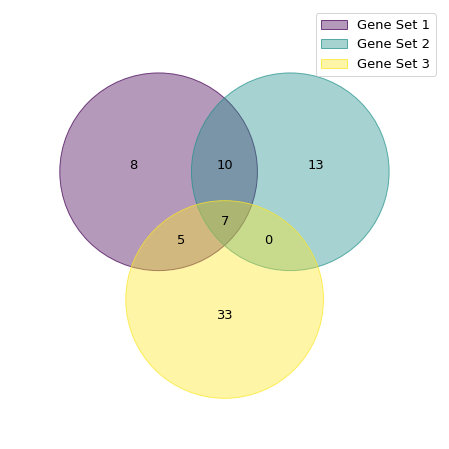

In [21]:
# Generate the venn diagram

if venndiagram:
    venn(gsdict, cmap = scheme)

    for plot_name in final_venn_file_names:
        pyplot.savefig(plot_name, bbox_inches = 'tight')
    
    figure_title("Figure 1", "Venn diagram")
    pyplot.show()
    figure_legend("Figure 1", "Venn diagram", "This Venn diagram compares the inputted gene sets and displays the intersections between them.")
    

    if len(gsdict) == 6:
        pseudovenn(gsdict)

In [ ]:
# Download Venn Diagrams
for i, file in enumerate(final_venn_file_names):
    display(FileLink(file, result_html_prefix=str('Download ' + venn_file_format[i] + ': ')))

## SuperVenn Diagram

In [ ]:
# SuperVenn
figure_title("Figure 2", "SuperVenn")
supervenn(list(gsdict.values()), list(gsdict.keys()), sets_ordering= 'minimize gaps', widths_minmax_ratio=0.1, min_width_for_annotation=180)
figure_legend("Figure 2", "SuperVenn", "The numbers on the right represent the set sizes and the numbers on the top show how many sets the intersection is part of. The overlapping portions of the colored bars correspond to set intersections.")

## UpSet Plot

In [ ]:
# UpSet Plots
if upset:
    df = from_contents(gsdict)
    plot(df, orientation = orient.lower(), facecolor = color, show_counts = counts, show_percentages = percent)
    for plot_name in final_output_file_names:
        pyplot.savefig(plot_name, bbox_inches = 'tight')
    
    figure_title("Figure 3", "UpSet Plot")
    pyplot.show()
    figure_legend("Figure 3", "UpSet Plot", "This UpSet plot displays the set intersections as a matrix with the cardinalities shown as bars.")
    

In [ ]:
# Download UpSet Plots
for i, file in enumerate(final_output_file_names):
    display(FileLink(file, result_html_prefix = str('Download ' + figure_file_format[i] + ': ')))

## List of Set Intersections

In [ ]:
#Linking to Enrichr
def enrichr_link(gene_list):
    ENRICHR_URL = 'http://amp.pharm.mssm.edu/Enrichr/addList' 
    genes_str = '\n'.join(gene_list)
    description = 'Example Gene List'
    payload = {
        'list': (None, genes_str),
        'description': (None, description)
    }

    response = requests.post(ENRICHR_URL, files=payload)
    if not response.ok:
        raise Exception('Error analyzing gene list')

    time.sleep(0.5)

    data = json.loads(response.text)

    short_id = data['shortId']
    return [str(short_id)]


In [ ]:
def get_venn_sections(sets):
    num_combinations = 2 ** len(sets)
    bit_flags = [2 ** n for n in range(len(sets))]
    flags_zip_sets = [z for z in zip(bit_flags, sets)]

    combo_sets = []
    for bits in range(num_combinations - 1, 0, -1):
        include_sets = [s for flag, s in flags_zip_sets if bits & flag]
        exclude_sets = [s for flag, s in flags_zip_sets if not bits * flag]
        combo = set.intersection(*include_sets)
        combo = set.difference(combo, *exclude_sets)
        tag = ''.join([str(int((bits & flag) > 0)) for flag in bit_flags])
        combo_sets.append((tag, combo))
    return combo_sets

In [ ]:
sets = list(gsdict.values())

In [ ]:
def generate_name(combos):
    tag_list = []
    for pair in combos:
        bits = pair[0]
        inter = '('
        diff = '('
        for i in range(len(bits)):
            j = i+1
            set_name = 'Set ' +  str(j)
            if bits[i] == '1':
                inter += set_name
                inter += ' & '
            else:
                diff += set_name
                diff += ' U '

        final_inter = inter[:-3]
        final_inter += ')'
        final_diff = diff[:-3]
        final_diff += ')'

        if final_diff != ')':
            final_name = final_inter + ' - ' + final_diff
        else:
            final_name = final_inter[1:-1]
        tag_list.append(final_name)
    return tag_list

In [ ]:
# Generates visibility booleans for dropdown menu

def generate_visibility(options):
    bools = []
    temp = []
    for x in range (len(options)):
        temp.append(False)
    for x in range(len(options)):
        visible = temp.copy()
        visible[x] = True
        bools.append(visible)
    
    return bools

In [ ]:
# Creates the options for the dropdown menu
def make_options(tuples, names):
    bools = generate_visibility(tuples)
    dropdown = []
    for x in range (len(tuples)):
        option = dict(
            args = [{'visible': bools[x]}],
            label = names[x],
            method = "update"
        )
        dropdown.append(option)
    return dropdown

In [ ]:
def create_enrichr_link(l1):
    results = enrichr_link(l1)
    final_str = str('https://amp.pharm.mssm.edu/Enrichr/enrich?dataset='+ results[0])
    return final_str

In [ ]:
# Add Enrichr Links
def add_links():
    l1 = []
    for pair in get_venn_sections(sets):
        temp = pair
        new_tuple = temp + tuple(create_enrichr_link(pair[1]).split(' '))
        l1.append(new_tuple)
    return l1

new_venn_sections = add_links()

In [ ]:
# Create Figure for Set Intersection Item Dropdown
fig = go.Figure()

for pair in new_venn_sections:
    fig.add_trace(
        go.Table(
            header = dict(
                values = ['Intersection Listing', 'Extra Info'],
                line_color = '#001C55',
                fill_color = '#001C55',
                align = ['left', 'center'],
                font=dict(color='white', size=16)
            ),
            cells = dict(
                values = [list(pair[1]), ['Size: ' + str(len(list(pair[1]))) + ' items', 'Access your complete Enrichment results here: ' + str(pair[2])]],
                line_color = 'white',
                fill_color = '#f5f5f5',
                align = ['left', 'center'],
                font = dict(color = 'darkslategray', size = 14)
            )
        )
    )
## Make Dropdown

fig.update_layout(
    updatemenus = [
        dict(
        buttons=list(make_options(get_venn_sections(sets), generate_name(get_venn_sections(sets)))),
        direction = "down",
        pad = {"r": 10, "t": 10},
        showactive = True,
        x = 0,
        xanchor = "left",
        y = 1.2,
        yanchor = "top"
    ),
    ]
)

figure_title("Table 1", "List of Set Intersections")
fig.show()
display(HTML(f"<div><b>Explanation of Symbols</b>: <br><i>A - B </i> - subtraction of set B from set A</br> <br><i>A & B </i> - intersection of sets A and B</br> <br><i>A U B </i> - union of sets A and B</br> </div>"))
figure_legend("Table 1", "List of Set Intersections", "This table shows the elements contained in each set intersection. A link to Enrichr for further enrichment analysis is provided. Various intersections can be found using the dropdown menu.")

## Fisher's Exact Test Calculations

In [ ]:
# Pair the Gene Sets
matching = []

gene_sets = list(gsdict.keys())
for i in range (len(gene_sets)-1):
    for j in range (i+1, len(gene_sets)):
        matching.append((gene_sets[i], gene_sets[j]))

In [ ]:
# Generates values for Fisher's Exact Test

def generate_values(s1, s2):
    inter = len(s1 & s2)
    not_A_not_B = background - (len(s1) + len(s2) - inter)
    in_A_not_B = len(s1) - inter
    not_A_in_B = len(s2) - inter
    total = not_A_not_B + not_A_in_B + in_A_not_B + inter

    oddsratio, pvalue = stats.fisher_exact([[not_A_not_B, in_A_not_B], [not_A_in_B, inter]])

    if pvalue < significance:
        sig_result = 'This result is <b>significant</b> at p < ' + str(significance)
    else:
        sig_result = 'This result is <b>not significant</b> at p < ' + str(significance)

    values1 = [['<b>Not in B</b>', '<b>In B</b>', '<b>Marginal Column Totals</b>', '<b>p-value</b>: ' + str(pvalue), '<b>Odds Ratio</b>: ' + str(oddsratio), '<b>Result</b>: ' + sig_result], [not_A_not_B, not_A_in_B, not_A_not_B+not_A_in_B], [in_A_not_B, inter, in_A_not_B+inter], [not_A_not_B+in_A_not_B, not_A_in_B+inter, str(total) + ' (Grand Total)']]

    return values1

In [ ]:
# Create figure and adds all tables
fig2 = go.Figure()

for pair in matching:
    fig2.add_trace(
        go.Table(
            header = dict(
                values = ['', '<b>Not in A</b>', '<b>In A</b>', '<b>Marginal Row Totals</b>'],
                line_color = '#001C55',
                fill_color = '#001C55',
                align = ['left', 'center'],
                font=dict(color='white', size=12)
            ),
            cells = dict(
                values = generate_values(gsdict[pair[0]], gsdict[pair[1]]),
                line_color = 'white',
                fill_color = [['#f5f5f5', '#f5f5f5', '#f5f5f5', 'white', 'white', 'white']*4],
                align = ['left', 'center'],
                font = dict(color = 'darkslategray', size = 11)
            )
        )
    )

In [ ]:
# Generates names for dropdown menu
def generate_names():
    names = []
    for pair in matching:
        s = pair[0] + ' & ' + pair[1]
        names.append(s)
    return names

In [ ]:
# Generates figure with dropdown menu
names = generate_names()

fig2.update_layout(
    updatemenus = [
        dict(
            buttons=list(make_options(matching, names)),
            direction = "down",
            pad = {"r": 10, "t": 10},
            showactive = True,
            x = 0,
            xanchor = "left",
            y = 1.2,
            yanchor = "top"
        ),
    ]
)

figure_title("Table 2", "Fisher's Exact Test")

fig2.show()

figure_legend("Table 2", "Fisher's Exact Test", "This table shows the results of Fisher's Exact Test. Using the items in the contigency table, the p-value and odds ratio is calculated. The p-value is then compared against the desired significance level. The overlap between various sets can be seen using the dropdown menu.")

## Heatmap of Fisher's Exact Test Results

In [3]:
def reverse(tuples):
    new_tup = ()
    for k in reversed(tuples):
        new_tup += (k, )
    return new_tup

(3, 2, 1)


In [ ]:
def check_sig(s1, s2):
    inter = len(s1 & s2)
    not_A_not_B = background - (len(s1) + len(s2) - inter)
    in_A_not_B = len(s1) - inter
    not_A_in_B = len(s2) - inter
    total = not_A_not_B + not_A_in_B + in_A_not_B + inter

    oddsratio, pvalue = stats.fisher_exact([[not_A_not_B, in_A_not_B], [not_A_in_B, inter]])

    if pvalue < significance:
        return 1
    else:
        return 0

In [ ]:
def heatmap_values(gene_sets):
    values = []
    x_axis = gene_sets
    y_axis = gene_sets
    for i in range (len(x_axis)):
        row = []
        for j in range (len(y_axis)):
            t = (x_axis[i], y_axis[j])
            if t in matching:
                row.append(check_sig(gsdict[x_axis[i]], gsdict[y_axis[j]]))
            elif reverse(t) in matching:
                row.append(check_sig(gsdict[y_axis[j]], gsdict[x_axis[i]]))
            else:
                row.append(None)
        values.append(row)
    return values

In [ ]:
fig3 = go.Figure(data = go.Heatmap(
                    z = heatmap_values(gene_sets),
                    x = gene_sets,
                    y = gene_sets,
                    hoverongaps = False))
figure_title("Figure 4", "Heatmap of Fisher's Exact Test Results")
fig3.show()
figure_legend("Figure 4", "Heatmap of Fisher's Exact Test Results", "This figure displays the results of all Fisher's Exact Tests calculated. Each axis displays which sets are being compared. Having a value of 1 indicates that the overlap is significant, while a value of 0 indicates that the overlap is not significant. Sets that cannot be compared are given a value of None.")